<a href="https://colab.research.google.com/github/IsmaelOuahchi/IsmaelOuahchi/blob/main/Stage_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import

In [ ]:
 import lightgbm as lgb
 import numpy as np
 import re
from sklearn.ensemble import IsolationForest
# !pip install shap
# import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/application_train.csv'
df = pd.read_csv(file_path)
print(df.shape)


Mounted at /content/drive
(307511, 122)


# Data Understanding

In [ ]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
print('Data shape: ', df.shape)

Data shape:  (307511, 122)


In [ ]:
print(df.dtypes)


SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object


The dataset is not balanced with respect to the target:

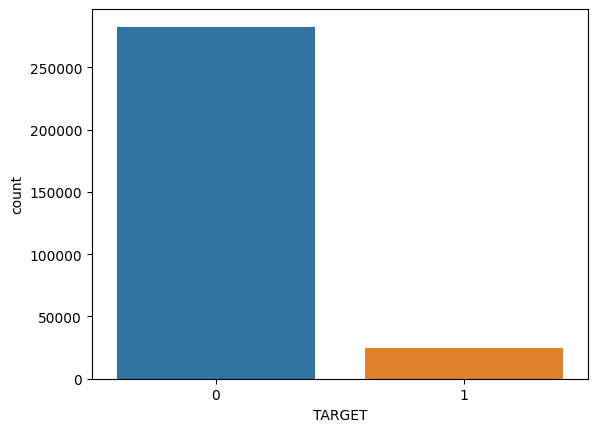

In [ ]:
sns.countplot(x="TARGET",data=df);

Finding the most corrolated feature with respect to the target:


In [ ]:
# Find correlations with the target and sort
correlations = df.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(9))
print('\nMost Negative Correlations:\n', correlations.head(7))

<ipython-input-9-3865a6db5b35>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()['TARGET'].sort_values()


Most Positive Correlations:
 REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3     -0.178919
EXT_SOURCE_2     -0.160472
EXT_SOURCE_1     -0.155317
DAYS_EMPLOYED    -0.044932
FLOORSMAX_AVG    -0.044003
FLOORSMAX_MEDI   -0.043768
FLOORSMAX_MODE   -0.043226
Name: TARGET, dtype: float64


In [ ]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


# Data Preparation

#### Feature Importance

We remove 4 entries with CODE_GENDER=XNA

In [ ]:
  df = df[df['CODE_GENDER'] != 'XNA']

We remove features that are highly corrolated to one another

In [ ]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = df.corr().abs()


# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

<ipython-input-13-0750555d3948>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()
<ipython-input-13-0750555d3948>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,NaN,0.002111,0.001120,0.001821,0.000350,0.000440,0.000241,0.000852,0.001500,0.001361,0.000973,0.000389,0.001821,0.002804,0.001332,0.000395,0.002815,0.002769,0.000278,0.002885,0.001067,0.001130,0.000354,0.000284,0.001095,0.002901,0.001888,0.001588,0.000063,0.000077,0.002342,0.000209,0.001548,0.002071,0.001553,0.005914,0.001460,0.004855,0.002885,0.004841,0.003077,0.001461,0.003119,0.001763,0.002576,0.003039,0.001954,0.001412,0.001892,0.005259,0.001056,0.005011,0.002849,0.004376,0.002075,0.001544,0.003589,0.002149,0.001924,0.001917,0.001980,0.001648,0.001368,0.005792,0.001034,0.005060,0.002588,0.004578,0.002830,0.001695,0.003272,0.002198,0.003021,0.002438,0.002282,0.001413,0.000091,0.001427,0.001177,0.000851,0.000700,0.003427,0.004139,0.001098,0.002118,0.002694,0.001806,0.001504,0.000815,0.002013,0.001045,0.000896,0.001078,0.002603,0.000725,0.001450,0.000508,0.000167,0.001072,0.000282,0.002673,0.002194,0.002097,0.000498,0.001019,0.004661
TARGET,NaN,NaN,0.019189,0.003982,0.030371,0.012818,0.039647,0.037225,0.078242,0.044934,0.041976,0.051457,0.037611,0.000534,0.045984,0.028533,0.000370,0.023801,0.001759,0.009310,0.058901,0.060895,0.024164,0.005575,0.006941,0.002819,0.044394,0.050992,0.032517,0.155317,0.160471,0.178926,0.029502,0.022747,0.009727,0.022150,0.018551,0.034202,0.019175,0.044009,0.033619,0.010887,0.025034,0.033001,0.003177,0.013580,0.027288,0.019953,0.009036,0.022069,0.016342,0.032135,0.017390,0.043231,0.032703,0.010176,0.023397,0.030688,0.001557,0.012712,0.029188,0.022082,0.009993,0.022326,0.018574,0.033866,0.019028,0.043773,0.033400,0.011258,0.024624,0.032743,0.002758,0.013338,0.032599,0.009136,0.032261,0.009027,0.031295,0.055219,0.005417,0.044341,0.002672,0.000316,0.028603,0.001520,0.008042,0.004353,0.001414,0.004230,0.000756,0.011583,0.009464,0.006536,0.011615,0.003378,0.007953,0.001358,0.000215,0.003709,0.000930,0.002704,0.000787,0.012460,0.002022,0.019934
CNT_CHILDREN,NaN,NaN,NaN,0.012884,0.002151,0.021381,0.001818,0.025577,0.330937,0.239818,0.183387,0.028014,0.008492,0.001041,0.240713,0.055620,0.000794,0.029916,0.022620,0.

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 40 columns to remove.


In [ ]:
df = df.drop(columns = to_drop)


We will now remove features that have more that 60% missing value.

In [ ]:
missing = (df.isnull().sum() / len(df)).sort_values(ascending = False)
filtered_missing = missing[missing >0.6]
filtered_missing = list(filtered_missing.index)

print(filtered_missing)
print('There are %d columns with more than 60%% missing values' % len(filtered_missing))

['COMMONAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE', 'FLOORSMIN_AVG', 'YEARS_BUILD_AVG', 'OWN_CAR_AGE']
There are 6 columns with more than 60% missing values


In [ ]:
df = df.drop(columns=filtered_missing)
df.shape

(307507, 76)

In [ ]:
print(df.shape)

(307507, 76)


We will now remove the features that are the least corrolated to the

In [ ]:
# Find correlations with the target and sort
correlations = df.corr()['TARGET'].abs().sort_values()

# closest_to_zero = correlations.nsmallest(5)
# print('Most Positive Correlations:\n', correlations.tail(9))
print('\nMost Negative Correlations:\n', correlations.head(47))

<ipython-input-19-09627252f90a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()['TARGET'].abs().sort_values()



Most Negative Correlations:
 FLAG_DOCUMENT_20               0.000215
FLAG_DOCUMENT_5                0.000316
FLAG_CONT_MOBILE               0.000370
FLAG_MOBIL                     0.000534
FLAG_DOCUMENT_12               0.000756
AMT_REQ_CREDIT_BUREAU_WEEK     0.000787
AMT_REQ_CREDIT_BUREAU_HOUR     0.000930
FLAG_DOCUMENT_19               0.001358
FLAG_DOCUMENT_10               0.001414
FLAG_DOCUMENT_7                0.001520
FLAG_EMAIL                     0.001759
AMT_REQ_CREDIT_BUREAU_QRT      0.002022
SK_ID_CURR                     0.002111
FLAG_DOCUMENT_4                0.002672
AMT_REQ_CREDIT_BUREAU_DAY      0.002704
FLAG_DOCUMENT_17               0.003378
FLAG_DOCUMENT_21               0.003709
AMT_INCOME_TOTAL               0.003982
FLAG_DOCUMENT_11               0.004230
FLAG_DOCUMENT_9                0.004353
FLAG_DOCUMENT_2                0.005417
REG_REGION_NOT_LIVE_REGION     0.005575
FLAG_DOCUMENT_15               0.006536
REG_REGION_NOT_WORK_REGION     0.006941
FLAG_DOCUM

In [ ]:
closest_to_zero = correlations.head(47)
closest_to_zero = closest_to_zero.drop(['SK_ID_CURR']).index.tolist()
print(len(closest_to_zero))
print(closest_to_zero)

46
['FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_5', 'FLAG_CONT_MOBILE', 'FLAG_MOBIL', 'FLAG_DOCUMENT_12', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_7', 'FLAG_EMAIL', 'AMT_REQ_CREDIT_BUREAU_QRT', 'FLAG_DOCUMENT_4', 'AMT_REQ_CREDIT_BUREAU_DAY', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_21', 'AMT_INCOME_TOTAL', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_2', 'REG_REGION_NOT_LIVE_REGION', 'FLAG_DOCUMENT_15', 'REG_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_8', 'OBS_30_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_14', 'YEARS_BEGINEXPLUATATION_AVG', 'LANDAREA_AVG', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_16', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_ANNUITY', 'NONLIVINGAREA_AVG', 'ENTRANCES_AVG', 'CNT_CHILDREN', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'BASEMENTAREA_AVG', 'FLAG_PHONE', 'HOUR_APPR_PROCESS_START', 'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_6', 'APARTMENTS_AVG', 'AMT_CREDIT', 'DEF_30_CNT_SOCIAL_CIRCLE', 'REGION_POPULATION_RELATIVE']


In [ ]:
df = df.drop(columns = closest_to_zero)
print(df.shape)


(307507, 30)


In [ ]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)


#### Label encoding

Convert all Label feature into one hot.

In [ ]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,SK_ID_CURR,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,100002,1,-9461,-637.0,-3648.0,-2120,2,0,0,0.083037,0.262949,0.139376,0.0

Convert strings into numerical labels.

In [ ]:
columns_to_encode = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

for col in columns_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # storing the label encoder

df.head()

,SK_ID_CURR,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,100002,1,-9461,-637.0,-3648.0,-2120,2,0,0,0.083037,0.262949,0.139376,0.0

#### Missing Values

In [ ]:
# sns.countplot(x="WEEKDAY_APPR_PROCESS_START_SUNDAY",hue="TARGET",data=df);
cat_features = df.select_dtypes(include=['int64']).columns.tolist()
cat_features

['SK_ID_CURR',
 'TARGET',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'REGION_RATING_CLIENT',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_3']

In [ ]:
cat_features = df.select_dtypes(include=['uint8']).columns.tolist()
cat_features.append(['REGION_RATING_CLIENT',
                     'REG_CITY_NOT_LIVE_CITY',
                     'REG_CITY_NOT_WORK_CITY',
                     'FLAG_DOCUMENT_3'])

In [ ]:
for col in cat_features:
    mode_val = df[col].mode().iloc[0]
    df[col].fillna(value=mode_val, inplace=True)

<ipython-input-27-eb5d999f99e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(value=mode_val, inplace=True)
<ipython-input-27-eb5d999f99e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(value=mode_val, inplace=True)
<ipython-input-27-eb5d999f99e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [ ]:
# Fill other columns with median
for col in df.columns:
    if col not in cat_features:
        median_val = df[col].median()
        df[col].fillna(value=median_val, inplace=True)

In [ ]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(20)

Your selected dataframe has 135 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### Combining other tables

In [ ]:
# drive.mount('/content/drive')

bb = pd.read_csv('/content/drive/MyDrive/bureau_balance.csv')


In [ ]:
print(bb.shape)
bb.head()


(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
# Missing values statistics
missing_values = missing_values_table(bb)
missing_values.head(20)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Convert bb label features into one hot



In [ ]:
bb = pd.get_dummies(bb, drop_first=True)
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,1,0


Aggregate features

In [ ]:
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
columns_ = bb.columns
columns_ = columns_.tolist()
columns_.remove('MONTHS_BALANCE')
columns_.remove('SK_ID_BUREAU')

for col in columns_:
    bb_aggregations[col] = ['mean']

bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)

In [ ]:
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])


In [ ]:
print(bb_agg.shape)
bb_agg.head()

(817395, 10)


,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN
SK_ID_BUREAU,,,,,,,,,,
5001709,-96,0,97,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402
5001710,-82,0,83,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446
5001711,-3,0,4,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000
5001712,-18,0,19,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000
5001713,-21,0,22,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000


Now we work on the parent dataframe: bureau.

In [ ]:
bureau = pd.read_csv('/content/drive/MyDrive/bureau.csv')
print(bureau.shape)
bureau.head()

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')


Convert bureau label features into one hot


In [ ]:
bureau_ = pd.get_dummies(bureau, drop_first= False)
bureau_.head()
new_bureau_columns = []
for col in bureau_:
  if col not in bureau.columns:
    new_bureau_columns.append(col)
print(new_bureau_columns)
# bureau = bureau_

['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt', 'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold', 'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2', 'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4', 'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan', 'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit', 'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit', 'CREDIT_TYPE_Loan for business development', 'CREDIT_TYPE_Loan for purchase of shares (margin lending)', 'CREDIT_TYPE_Loan for the purchase of equipment', 'CREDIT_TYPE_Loan for working capital replenishment', 'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan', 'CREDIT_TYPE_Mortgage', 'CREDIT_TYPE_Real estate loan', 'CREDIT_TYPE_Unknown type of loan']


In [ ]:
bureau = bureau_
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
print(bureau.shape)
bureau.head()

(1716428, 46)


,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,215354,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,215354,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,215354,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,215354,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Aggregation:

In [ ]:
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in new_bureau_columns: cat_aggregations[cat] = ['mean']
    for cat in columns_: cat_aggregations[cat + "_MEAN"] = ['mean']

In [ ]:
  bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
  bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [ ]:
print(bureau_agg.shape)
bureau_agg.head()

(305811, 57)


,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,NaN,378000.0,207623.571429,1453365.000,373239.0,85240.928571,596686.5,0.0,0.00000,0.000,10822.5,3545.357143,0,-51.0,0.0,24.571429,172.0,0.428571,0.0,0.571429,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007519,0.0,0.0,0.0,0.0,0.441240,0.214590
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,1681.029,450000.0,108131.945625,865055.565,245781.0,49156.200000,245781.0,0.0,7997.14125,31988.565,0.0,0.000000,0,-47.0,0.0,13.750000,110.0,0.250000,0.0,0.750000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255682,0.0,0.0,0.0,0.0,0.175426,0.161932
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,0.000,810000.0,254350.125000,1017400.500,0.0,0.000000,0.0,0.0,202500.00000,810000.000,NaN,NaN,0,NaN,NaN,NaN,0.0,0.250000,0.0,0.750000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,0.000,94537.8,94518.900000,189037.800,0.0,0.000000,0.0,0.0,0.00000,0.000,NaN,NaN,0,NaN,NaN,NaN,0.0,0.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,0.000,568800.0,219042.000000,657126.000,543087.0,189469.500000,568408.5,0.0,0.00000,0.000,4261.5,1420.500000,0,-12.0,0.0,7.000000,21.0,0.666667,0.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.128205,0.136752


In [ ]:
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')


In [ ]:
print(bureau_agg.shape)


(305811, 111)


In [ ]:
final_df = df.join(bureau_agg, how='left', on='SK_ID_CURR')


In [ ]:
print(final_df.shape)
final_df.head()

(307507, 246)


,SK_ID_CURR,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_

In [ ]:
# Missing values statistics
missing_values = missing_values_table(final_df)
missing_values.head(20)

Your selected dataframe has 246 columns.
There are 111 columns that have missing values.


,Missing Values,% of Total Values
ACTIVE_AMT_ANNUITY_MAX,246161,80.1
ACTIVE_AMT_ANNUITY_MEAN,246161,80.1
CLOSED_AMT_ANNUITY_MAX,241498,78.5
CLOSED_AMT_ANNUITY_MEAN,241498,78.5
ACTIVE_MONTHS_BALANCE_MIN_MIN,230988,75.1
ACTIVE_MONTHS_BALANCE_SIZE_MEAN,230988,75.1
ACTIVE_MONTHS_BALANCE_MAX_MAX,230988,75.1
BURO_AMT_ANNUITY_MEAN,227498,74.0
BURO_AMT_ANNUITY_MAX,227498,74.0
CLOSED_MONTHS_BALANCE_MIN_MIN,226772,73.7


In [ ]:

def fill_missing_values(df):
    """
    Fills missing values of a DataFrame based on the following criteria:
    - If column name contains "ACTIVE" or "CLOSED", fill with 0.
    - If column is binary (0s and 1s or 0.0s and 1.0s), fill with mode.
    - Otherwise, fill with median.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: DataFrame with missing values filled.
    """

    for col in df.columns:
        # Check if column name contains "ACTIVE" or "CLOSED"
        if 'ACTIVE' in col or 'CLOSED' in col:
            df[col].fillna(0, inplace=True)
        # Check if column is binary
        elif df[col].dropna().isin([0, 1, 0.0, 1.0]).all():
            mode_value = df[col].mode().iloc[0] if not df[col].mode().empty else None
            if mode_value is not None:
                df[col].fillna(mode_value, inplace=True)
        else:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)

    return df

In [ ]:
final_df = fill_missing_values(final_df)


In [ ]:
print(final_df.shape)
final_df.head()

(307507, 246)


,SK_ID_CURR,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_

### Scaling

In [ ]:
scaler = MinMaxScaler()
final_df = pd.DataFrame(scaler.fit_transform(final_df), columns=final_df.columns)

### Outliers

In [ ]:
clf = IsolationForest(contamination=0.05) # Set the contamination parameter based on what portion of your data you believe to be outliers
outlier_pred = clf.fit_predict(final_df)
final_df = final_df[outlier_pred == 1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


# Modelling

In [ ]:
X = final_df.drop(columns = ['TARGET'])
y = final_df['TARGET']

def sanitize_column_names(df):
    """Sanitize column names by replacing non-alphanumeric characters with underscores."""
    df.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in df.columns]
    return df
X_train = sanitize_column_names(X)


In [ ]:

to_drop = ['CLOSED_MONTHS_BALANCE_MIN_MIN', 'ACTIVE_DAYS_CREDIT_MAX', 'BURO_MONTHS_BALANCE_SIZE_SUM', 'CLOSED_DAYS_CREDIT_VAR', 'OCCUPATION_TYPE_Sales_staff', 'ACTIVE_AMT_ANNUITY_MAX', 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN', 'DAYS_REGISTRATION', 'CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN', 'DAYS_EMPLOYED', 'BURO_AMT_CREDIT_SUM_SUM', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'BURO_DAYS_CREDIT_ENDDATE_MEAN', 'NAME_INCOME_TYPE_Working', 'BURO_CREDIT_TYPE_Mortgage_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'CLOSED_MONTHS_BALANCE_SIZE_MEAN', 'BURO_MONTHS_BALANCE_SIZE_MEAN', 'CLOSED_AMT_CREDIT_SUM_SUM', 'CLOSED_DAYS_CREDIT_MEAN', 'CLOSED_DAYS_CREDIT_MAX', 'ACTIVE_AMT_CREDIT_SUM_MAX', 'NAME_FAMILY_STATUS_Married', 'CLOSED_AMT_ANNUITY_MAX', 'NAME_EDUCATION_TYPE_Higher_education', 'OCCUPATION_TYPE_Core_staff', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_HOUSING_TYPE_House_apartment', 'BURO_CREDIT_ACTIVE_Sold_MEAN', 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM', 'REG_CITY_NOT_WORK_CITY', 'OCCUPATION_TYPE_Drivers', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'ACTIVE_MONTHS_BALANCE_MIN_MIN', 'ACTIVE_MONTHS_BALANCE_SIZE_SUM', 'NAME_INCOME_TYPE_State_servant', 'BURO_DAYS_CREDIT_MEAN', 'BURO_AMT_CREDIT_SUM_MAX', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN', 'CLOSED_AMT_CREDIT_SUM_MAX', 'NAME_INCOME_TYPE_Pensioner', 'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'ORGANIZATION_TYPE_Government', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'ORGANIZATION_TYPE_Industry_type_1', 'ORGANIZATION_TYPE_Housing', 'ORGANIZATION_TYPE_Industry_type_11', 'ORGANIZATION_TYPE_Industry_type_10', 'ORGANIZATION_TYPE_Industry_type_5', 'OCCUPATION_TYPE_Security_staff', 'ORGANIZATION_TYPE_Hotel', 'ORGANIZATION_TYPE_Business_Entity_Type_1', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'ORGANIZATION_TYPE_Industry_type_3', 'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Agriculture', 'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Industry_type_12', 'ORGANIZATION_TYPE_Industry_type_13', 'ORGANIZATION_TYPE_Culture', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Industry_type_4', 'ORGANIZATION_TYPE_Industry_type_2', 'ORGANIZATION_TYPE_Bank', 'ORGANIZATION_TYPE_Business_Entity_Type_2', 'OCCUPATION_TYPE_Waiters_barmen_staff', 'NAME_HOUSING_TYPE_Municipal_apartment', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Realty_agents', 'REG_CITY_NOT_LIVE_CITY', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group_of_people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse_partner', 'NAME_INCOME_TYPE_Commercial_associate', 'NAME_INCOME_TYPE_Maternity_leave', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_EDUCATION_TYPE_Incomplete_higher', 'NAME_EDUCATION_TYPE_Lower_secondary', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single_not_married', 'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'ORGANIZATION_TYPE_Industry_type_7', 'NAME_HOUSING_TYPE_Office_apartment', 'NAME_HOUSING_TYPE_Rented_apartment', 'NAME_HOUSING_TYPE_With_parents', 'OCCUPATION_TYPE_Cleaning_staff', 'OCCUPATION_TYPE_Cooking_staff', 'OCCUPATION_TYPE_HR_staff', 'OCCUPATION_TYPE_High_skill_tech_staff', 'OCCUPATION_TYPE_IT_staff', 'OCCUPATION_TYPE_Low_skill_Laborers', 'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine_staff', 'OCCUPATION_TYPE_Private_service_staff', 'ORGANIZATION_TYPE_Industry_type_6', 'CLOSED_MONTHS_BALANCE_SIZE_SUM', 'ORGANIZATION_TYPE_Industry_type_8', 'ACTIVE_AMT_CREDIT_SUM_SUM', 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN', 'ACTIVE_CREDIT_DAY_OVERDUE_MAX', 'BURO_STATUS_5_MEAN_MEAN', 'BURO_STATUS_4_MEAN_MEAN', 'BURO_STATUS_3_MEAN_MEAN', 'BURO_STATUS_2_MEAN_MEAN', 'BURO_CREDIT_TYPE_Unknown_type_of_loan_MEAN', 'BURO_CREDIT_TYPE_Real_estate_loan_MEAN', 'BURO_CREDIT_TYPE_Mobile_operator_loan_MEAN', 'BURO_CREDIT_TYPE_Loan_for_working_capital_replenishment_MEAN', 'BURO_CREDIT_TYPE_Loan_for_the_purchase_of_equipment_MEAN', 'BURO_CREDIT_TYPE_Loan_for_purchase_of_shares_margin_lending_MEAN', 'BURO_CREDIT_TYPE_Loan_for_business_development_MEAN', 'BURO_CREDIT_TYPE_Interbank_credit_MEAN', 'BURO_CREDIT_TYPE_Cash_loan_non_earmarked_MEAN', 'BURO_CREDIT_TYPE_Car_loan_MEAN', 'BURO_CREDIT_TYPE_Another_type_of_loan_MEAN', 'BURO_CREDIT_CURRENCY_currency_4_MEAN', 'BURO_CREDIT_CURRENCY_currency_3_MEAN', 'ACTIVE_AMT_CREDIT_SUM_MEAN', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX', 'BURO_CREDIT_CURRENCY_currency_1_MEAN', 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM', 'CLOSED_MONTHS_BALANCE_MAX_MAX', 'CLOSED_CNT_CREDIT_PROLONG_SUM', 'CLOSED_AMT_ANNUITY_MEAN', 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM', 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN', 'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN', 'CLOSED_AMT_CREDIT_SUM_DEBT_SUM', 'CLOSED_AMT_CREDIT_SUM_DEBT_MEAN', 'CLOSED_AMT_CREDIT_SUM_DEBT_MAX', 'CLOSED_AMT_CREDIT_SUM_MEAN', 'CLOSED_CREDIT_DAY_OVERDUE_MEAN', 'CLOSED_CREDIT_DAY_OVERDUE_MAX', 'CLOSED_DAYS_CREDIT_UPDATE_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_MONTHS_BALANCE_MAX_MAX', 'ACTIVE_CNT_CREDIT_PROLONG_SUM', 'ACTIVE_AMT_ANNUITY_MEAN', 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN', 'BURO_CREDIT_CURRENCY_currency_2_MEAN', 'BURO_CREDIT_ACTIVE_Bad_debt_MEAN', 'ORGANIZATION_TYPE_Industry_type_9', 'ORGANIZATION_TYPE_Trade_type_4', 'ORGANIZATION_TYPE_Trade_type_2', 'ORGANIZATION_TYPE_Trade_type_1', 'ORGANIZATION_TYPE_Telecom', 'ORGANIZATION_TYPE_Services', 'ORGANIZATION_TYPE_Security_Ministries', 'ORGANIZATION_TYPE_Security', 'ORGANIZATION_TYPE_School', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_Realtor', 'ORGANIZATION_TYPE_Postal', 'ORGANIZATION_TYPE_Police', 'ORGANIZATION_TYPE_Other', 'ORGANIZATION_TYPE_Mobile', 'ORGANIZATION_TYPE_Military', 'ORGANIZATION_TYPE_Medicine', 'ORGANIZATION_TYPE_Legal_Services', 'ORGANIZATION_TYPE_Kindergarten', 'ORGANIZATION_TYPE_Insurance', 'ORGANIZATION_TYPE_Trade_type_3', 'ORGANIZATION_TYPE_Trade_type_5', 'BURO_MONTHS_BALANCE_MAX_MAX', 'ORGANIZATION_TYPE_Trade_type_6', 'BURO_AMT_ANNUITY_MEAN', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX', 'BURO_DAYS_CREDIT_UPDATE_MEAN', 'EMERGENCYSTATE_MODE_Yes', 'WALLSMATERIAL_MODE_Wooden', 'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Mixed', 'HOUSETYPE_MODE_terraced_house', 'HOUSETYPE_MODE_specific_housing', 'ORGANIZATION_TYPE_XNA', 'ORGANIZATION_TYPE_University', 'ORGANIZATION_TYPE_Transport_type_3', 'ORGANIZATION_TYPE_Transport_type_2', 'ORGANIZATION_TYPE_Transport_type_1', 'ORGANIZATION_TYPE_Trade_type_7', 'ORGANIZATION_TYPE_Transport_type_4']
X_ = X.drop(columns = to_drop)


# Instantiate the SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to oversample the minority class
X_, y = smote.fit_resample(X_, y)





X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)


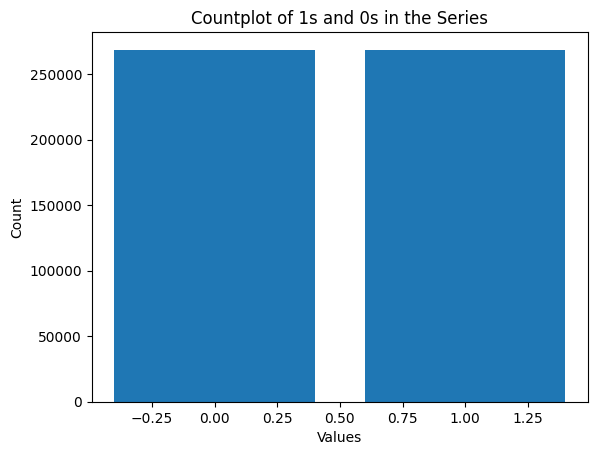

In [ ]:
# Create a sample pandas Series

# Count the occurrences of each unique value in the Series
value_counts = y.value_counts()

# Create a countplot using Matplotlib
plt.bar(value_counts.index, value_counts.values)

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Countplot of 1s and 0s in the Series')

# Show the plot
plt.show()

In [ ]:

model = LogisticRegression(C=0.5)
model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.5)

Accuracy: 0.69
Confusion Matrix:
[[36710 17175]
 [16404 37129]]


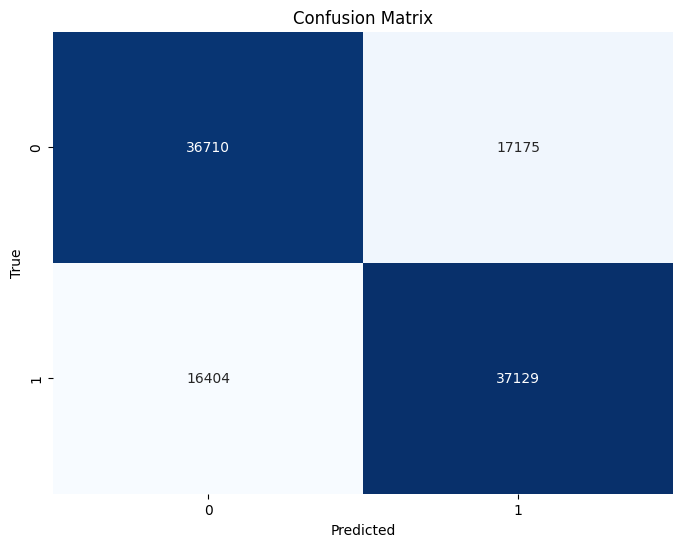

In [ ]:
y_pred_train = model.predict(X_test)
# accuracy
acc_training = accuracy_score(y_test, y_pred_train)
print(f'Accuracy: {acc_training:.2f}')

# confusion matrix
cm_ = confusion_matrix(y_test, y_pred_train)
print('Confusion Matrix:')
print(cm_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(X_train.shape)

(429670, 50)


## LGBM

In [ ]:

# Set hyperparameters
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': 100,
    'max_depth' : 70,
    'learning_rate': 0.005,
}
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)  # Set reference to the training dataset

# Train the model
num_round = 100
bst = lgb.train(params, train_data, 250)

# Make predictions
y_pred_gbm = bst.predict(X_test)

[LightGBM] [Info] Number of positive: 215011, number of negative: 214659
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.314203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12736
[LightGBM] [Info] Number of data points in the train set: 429670, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500410 -> initscore=0.001638
[LightGBM] [Info] Start training from score 0.001638


In [ ]:
y_pred_ = y_pred_gbm.copy()
for i in range(len(y_pred_gbm)):
  if y_pred_[i]<0.5:
    y_pred_[i] = 0
  else:
    y_pred_[i] = 1


Accuracy: 0.81
Confusion Matrix:
[[43752 10133]
 [10689 42844]]


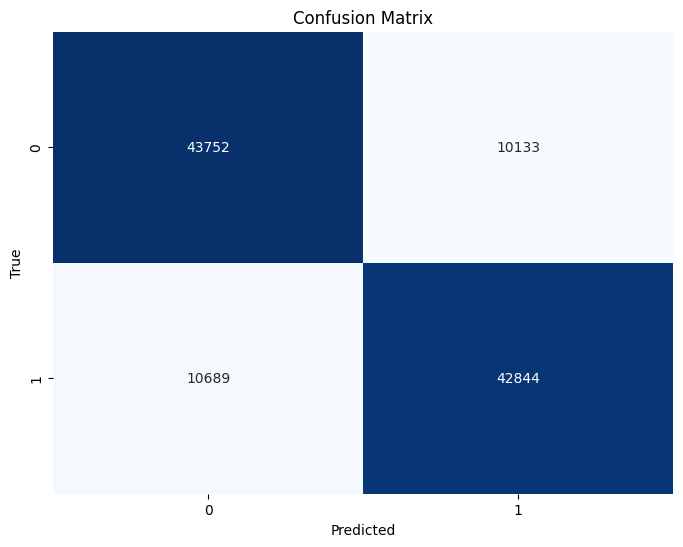

In [ ]:
# accuracy
accuracy_gbm = accuracy_score(y_test, y_pred_)
print(f'Accuracy: {accuracy_gbm:.2f}')

# confusion matrix
cm = confusion_matrix(y_test, y_pred_)
print('Confusion Matrix:')
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


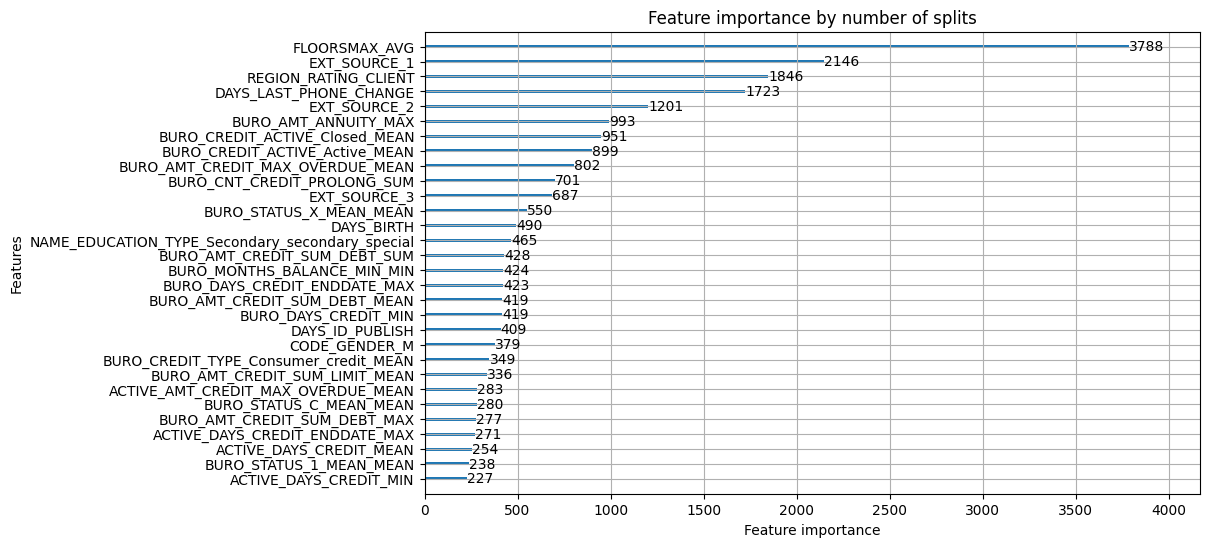

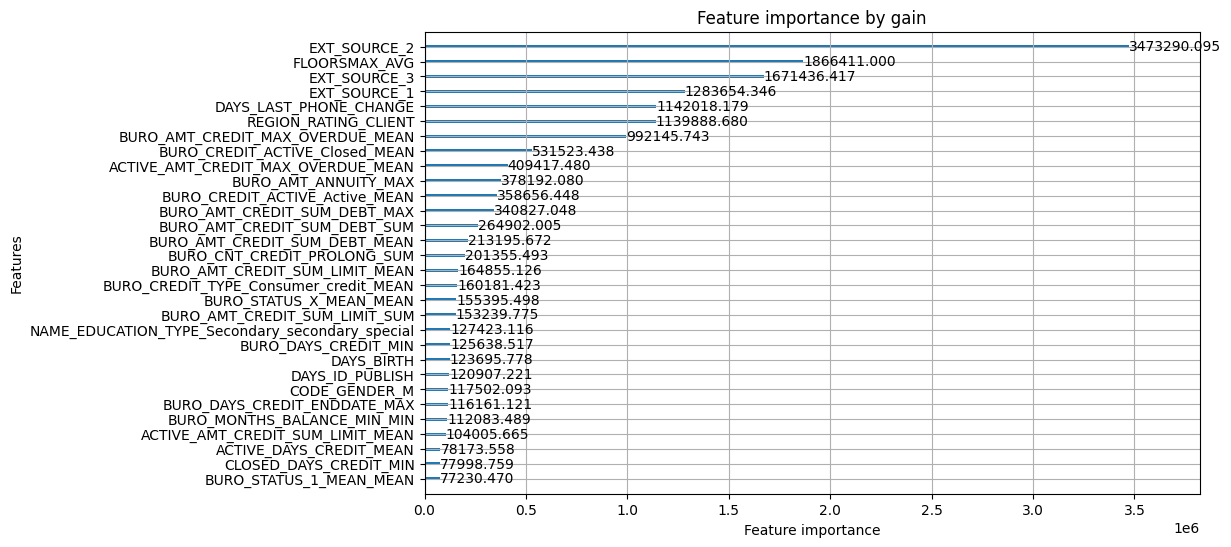

In [ ]:
lgb.plot_importance(bst, importance_type='split', max_num_features=30, figsize=(10, 6))
plt.title("Feature importance by number of splits")
plt.show()

lgb.plot_importance(bst, importance_type='gain', max_num_features=30, figsize=(10, 6))
plt.title("Feature importance by gain")
plt.show()






In [ ]:
feature_names = bst.feature_name()

# Importance based on number of splits
importance_split = bst.feature_importance(importance_type='split')
sorted_idx_split = importance_split.argsort()[::-1]  # sort in descending order
top_20_features_split = [feature_names[i] for i in sorted_idx_split[50:]]
print("Top 20 features by number of splits:")
print(top_20_features_split)

# Importance based on gain
importance_gain = bst.feature_importance(importance_type='gain')
sorted_idx_gain = importance_gain.argsort()[::-1]  # sort in descending order
top_20_features_gain = [feature_names[i] for i in sorted_idx_gain[50:]]
print("\nTop 20 features by gain:")
print(top_20_features_gain)

print("Top 20 features merged:")

merged_list = list(set(top_20_features_split) | set(top_20_features_gain))
print(merged_list)

Top 20 features by number of splits:
[]

Top 20 features by gain:
[]
Top 20 features merged:
[]


## Random Forest

In [ ]:
# Initialize the model with desired parameters. Here we're using 100 trees.
clf = RandomForestClassifier(n_estimators=25, random_state=42)

# Train the model
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, random_state=42)

Accuracy: 0.91
Confusion Matrix:
[[48561  4952]
 [ 4193 49717]]


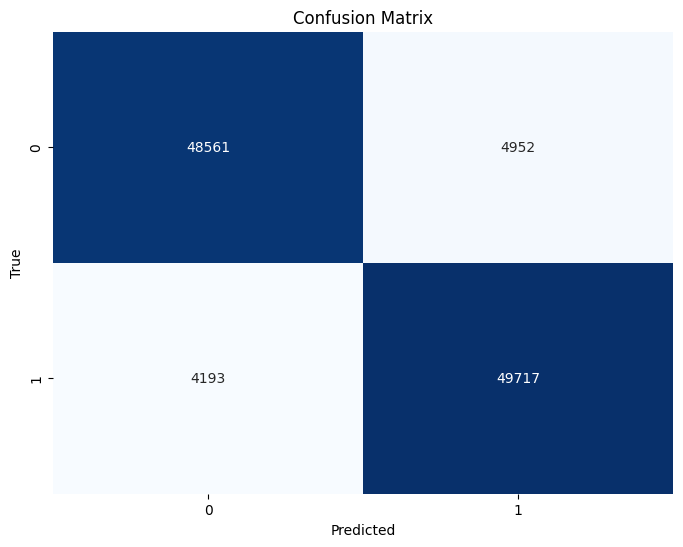

In [ ]:
y_pred_RF = clf.predict(X_test)
# accuracy
accuracy_gbm = accuracy_score(y_test, y_pred_RF)
print(f'Accuracy: {accuracy_gbm:.2f}')

# confusion matrix
cm = confusion_matrix(y_test, y_pred_RF)
print('Confusion Matrix:')
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import joblib
joblib.dump(clf, 'model.pkl')

['model.pkl']